In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

In [2]:
datasetw=pd.read_csv("FINAL_DATASET.csv")
datasetw.shape

(747, 4)

In [3]:
datasetw.head()

,Unnamed: 0,class,message,Category1
0,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Adultery
1,5,spam,FreeMsg Hey there darling it's been 3 week's n...,Adultery
2,8,spam,WINNER!! As a valued network customer you have...,Finance
3,9,spam,Had your mobile 11 months or more? U R entitle...,Adultery
4,11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",Miscellaneous


In [4]:
dfw = datasetw[['class','message','Category1']].copy()
dfw.head()

,class,message,Category1
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Adultery
1,spam,FreeMsg Hey there darling it's been 3 week's n...,Adultery
2,spam,WINNER!! As a valued network customer you have...,Finance
3,spam,Had your mobile 11 months or more? U R entitle...,Adultery
4,spam,"SIX chances to win CASH! From 100 to 20,000 po...",Miscellaneous


In [5]:
pd.DataFrame(dfw.Category1.unique()).values

array([['Adultery'],
       ['Finance'],
       ['Miscellaneous']], dtype=object)

In [6]:
# Create a new column 'category_id' with encoded categories 
dfw['category_id'] = dfw['Category1'].factorize()[0]
category_id_dfw = dfw[['Category1', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_idw = dict(category_id_dfw.values)
id_to_categoryw = dict(category_id_dfw[['category_id', 'Category1']].values)

# New dataframe
dfw.head()

,class,message,Category1,category_id
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Adultery,0
1,spam,FreeMsg Hey there darling it's been 3 week's n...,Adultery,0
2,spam,WINNER!! As a valued network customer you have...,Finance,1
3,spam,Had your mobile 11 months or more? U R entitle...,Adultery,0
4,spam,"SIX chances to win CASH! From 100 to 20,000 po...",Miscellaneous,2


In [7]:
category_id_dfw

,Category1,category_id
0,Adultery,0
2,Finance,1
4,Miscellaneous,2


In [9]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each cleaned_text into a vector
features = tfidf.fit_transform(dfw.message).toarray()

labels = dfw.category_id

print("Each of the %d text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 747 text is represented by 877 features (TF-IDF score of unigrams and bigrams)


In [10]:
# Finding the three most correlated terms with each of the categories
N = 3
for Category, category_id in sorted(category_to_idw.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Category))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Adultery:
  * Most Correlated Unigrams are: sexy, video, free
  * Most Correlated Bigrams are: free text, free ringtone, free entry

==> Finance:
  * Most Correlated Unigrams are: dating, service, customer
  * Most Correlated Bigrams are: guaranteed 1000, dating service, customer service

==> Miscellaneous:
  * Most Correlated Unigrams are: customer, service, free
  * Most Correlated Bigrams are: prize guaranteed, customer service, dating service


In [11]:
Xw = dfw['message'] # Collection of text
yw = dfw['Category1'] # Target or the labels we want to predict

X_trainw, X_testw, y_trainw, y_testw = train_test_split(Xw, yw, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [12]:
y_trainw.value_counts()

Miscellaneous    273
Adultery         182
Finance          105
Name: Category1, dtype: int64

In [13]:
y_testw.value_counts()

Miscellaneous    98
Adultery         54
Finance          35
Name: Category1, dtype: int64

In [14]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    GaussianNB()
]

# 5 Cross-validation
CV = 5
cv_dfw = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_dfw = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_dfw

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.746667
1,RandomForestClassifier,1,0.700000
2,RandomForestClassifier,2,0.684564
3,RandomForestClassifier,3,0.724832
4,RandomForestClassifier,4,0.718121
5,LinearSVC,0,0.933333
6,LinearSVC,1,0.906667
7,LinearSVC,2,0.932886
8,LinearSVC,3,0.899329
9,LinearSVC,4,0.892617


In [15]:
mean_accuracy = cv_dfw.groupby('model_name').accuracy.mean()
std_accuracy = cv_dfw.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
GaussianNB,0.760385,0.025964
LinearSVC,0.912966,0.019048
MultinomialNB,0.829987,0.021487
RandomForestClassifier,0.714837,0.023772


In [17]:
X_trainw, X_testw, y_trainw, y_testw,indices_trainw,indices_testw = train_test_split(features, 
                                                               labels, 
                                                               dfw.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_trainw, y_trainw)
y_predw = model.predict(X_testw)
calibrated_svc = CalibratedClassifierCV(base_estimator=model,
                                        cv="prefit")

calibrated_svc.fit(X_trainw,y_trainw)
predicted = calibrated_svc.predict(X_testw)
print(metrics.accuracy_score(y_testw, predicted))

0.9358288770053476


In [19]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_testw,predicted,labels=[0,1,2],target_names= dfw['Category1'].unique()))

				CLASSIFICATIION METRICS

               precision    recall  f1-score   support

     Adultery       0.94      0.95      0.94        63
      Finance       0.86      0.94      0.90        32
Miscellaneous       0.97      0.92      0.94        92

     accuracy                           0.94       187
    macro avg       0.92      0.94      0.93       187
 weighted avg       0.94      0.94      0.94       187



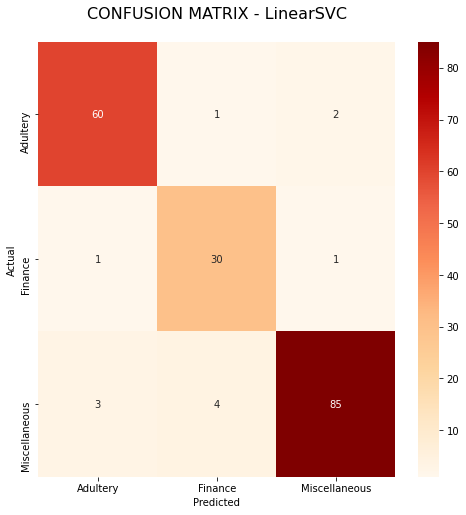

In [21]:
conf_mat = confusion_matrix(y_testw, predicted,labels=[0,1,2])
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="OrRd", fmt='d',
            xticklabels=category_id_dfw.Category1.values, 
            yticklabels=category_id_dfw.Category1.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [27]:
for predicted in category_id_dfw.category_id:
    for actual in category_id_dfw.category_id:
        if predicted != actual and conf_mat[actual, predicted] >0:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_categoryw[actual],id_to_categoryw[predicted],
                                                                   conf_mat[actual, predicted]))
            display(dfw.loc[indices_testw[(y_testw == actual) & (y_predw == predicted)]][['Category1', 
                                                                'message']])

'Finance' predicted as 'Adultery' : 1 examples.


,Category1,message
556,Finance,"SPJanuary Male Sale! Hot Gay chat now cheaper,..."


'Miscellaneous' predicted as 'Adultery' : 3 examples.


,Category1,message
612,Miscellaneous,FreeMsg Hi baby wow just got a new cam moby. W...
443,Miscellaneous,RCT' THNQ Adrian for U text. Rgds Vatian


'Adultery' predicted as 'Finance' : 1 examples.


,Category1,message
207,Adultery,As a registered optin subscriber ur draw 4 å£1...


'Miscellaneous' predicted as 'Finance' : 4 examples.


,Category1,message
364,Miscellaneous,we tried to contact you re your response to ou...
108,Miscellaneous,"Do you realize that in about 40 years, we'll h..."
502,Miscellaneous,"Claim a 200 shopping spree, just call 08717895..."


'Adultery' predicted as 'Miscellaneous' : 2 examples.


,Category1,message
195,Adultery,Ur balance is now å£500. Ur next question is: ...
610,Adultery,"I want some cock! My hubby's away, I need a re..."


'Finance' predicted as 'Miscellaneous' : 1 examples.


,Category1,message
670,Finance,You can donate å£2.50 to UNICEF's Asian Tsunam...
651,Finance,YOU HAVE WON! As a valued Vodafone customer ou...
526,Finance,YOU HAVE WON! As a valued Vodafone customer ou...


In [28]:
model.fit(features, labels)

N = 4
for Category, category_id in sorted(category_to_idw.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Category))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Adultery':
  * Top unigrams: free, video, xxx, sexy
  * Top bigrams: min stop, free entry, stop end, 60p min

==> 'Finance':
  * Top unigrams: customer, service, credit, gift
  * Top bigrams: send stop, dating service, guaranteed 1000, customer services

==> 'Miscellaneous':
  * Top unigrams: bt, sp, cash, 50p
  * Top bigrams: operator claim, prize claim, bt national, sms ac


In [29]:
X_trainw, X_testw, y_trainw, y_testw = train_test_split(Xw, dfw['category_id'], 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_trainw)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_trainw)

m = LinearSVC().fit(tfidf_vectorizer_vectors, y_trainw)
m1=CalibratedClassifierCV(base_estimator=m,
                                        cv="prefit").fit(tfidf_vectorizer_vectors, y_trainw)


In [30]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
from collections import Counter
import pandas as pd
import os
class ScrapTool:
    def visit_url(self, website_url):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'}
        content = requests.get(website_url,headers=headers,timeout=20).content
        
        #lxml is apparently faster than other settings.
        soup = BeautifulSoup(content, "lxml")
        result = {
#             "website_url": website_url,
            "message": self.get_message(message)
#             "title_tag_content": self.get_html_title_tag(soup),
#             "meta_tag_content": self.get_html_meta_tags(soup),
#             "headings_content": self.get_html_heading_tags(soup),
#             "html_text_content": self.get_text_content(soup)
        }
        #get_tag_count returns a dynamic dictionary. That is why we update the dictionary with a separate update command.
        result.update(self.get_tag_count(soup))
        
        #Convert to Series object and return
        return pd.Series(result)
    
    def get_message(self,message):
        return message
    

In [32]:
message=input('enter message: ')
# scrapTool = ScrapTool()
try:
    text=message
    t=fitted_vectorizer.transform([text])
    print(id_to_categoryw[m1.predict(t)[0]])
    data=pd.DataFrame(m1.predict_proba(t)*100,columns=dfw['Category1'].unique())
    data=data.T
    data.columns=['Probability']
    data.index.name='Category1'
    a=data.sort_values(['Probability'],ascending=False)
    a['Probability']=a['Probability'].apply(lambda x:round(x,2))
except:
    print("Connection Timedout!")

enter message: Congrats 81699228XX, Rs.1500 Welcome Bonus. PUN vs GUJ, T20 Match on My11Circle. Prize Pool - 6,82,00,000 (6.82Cr). Click - http://2lm.in/uqyfiH
Miscellaneous


In [33]:
a


,Probability
Category1,
Miscellaneous,96.86
Adultery,2.78
Finance,0.36


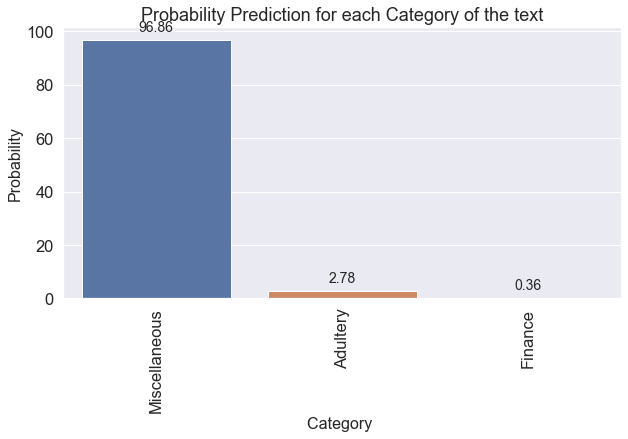

In [34]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(10,5))
i=list(a.index)
ax= sns.barplot(i,a['Probability'])

plt.title("Probability Prediction for each Category of the text", fontsize=18)
plt.ylabel('Probability', fontsize=16)
plt.xlabel('Category ', fontsize=16)

#adding the text labels
rects = ax.patches
labels = a['Probability']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 2, label, ha='center', va='bottom', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.show()